In [17]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from shallow_water import PeriodicLinearShallowWater
from plotting import plot_wind_arrows

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [256]:
def run_linear_model(beta=2.28e-11, equivalent_depth=10, Q0=3, matgill_yexp=2):
    """
    Params:
    
     - Radius of deformation: Rd = sqrt(2 c / beta)
     - beta
     
     
    # Question: What is the best thing to interpret as a 'free parameter'?
    
    Currently, James views Rd as a free parameter, but really that should be
    SET by the beta parameter and equivalent depth, right? That is much
    more physical I think. Will try to adapt the code. :)
    """
    nx = 256
    ny = nx//2 + 1


    # Radius of deformation: Rd = sqrt(2 c / beta)
    #Rd = 1000.0e3  # Fix Rd at 1000km

    Lx = 10e6 #10*Rd
    Ly = 5e6 #5*Rd

    
    g = 9.81
    # Kelvin wave speed: c = sqrt(gh)
    c = np.sqrt(g*equivalent_depth)  # Rd**2 * beta

    Rd = np.sqrt(c/beta) # Equatorial deformation radius
    print(f"Equatorial deformation radius = {Rd/1e3} (km)")
    
    H = c**2/g       # Set phi baseline from deformation radius

    cfl = 0.7         # For numerical stability CFL = |u| dt / dx < 1.0
    dx  = Ly / nx
    dt = np.floor(cfl * dx / (c*4))

    tau = 500000
    nu = 1000

    atmos = PeriodicLinearShallowWater(nx, ny, Lx, Ly, beta=beta, f0=0.0, g=g, H=H, dt=dt, nu=nu)

    # divide by Rd would mean size of perturbation scales with Rd
    # which is not what we're interested in...
    # So instead just scale by 1000km
    x, y = np.meshgrid(atmos.phix/1e6, atmos.phiy/1e6) 
    k = np.pi/2
    # Added -ve sign so it's representative of the low-level flow
    # i.e. a negative pressure anom (from deep convection)
    Q = -1*(Q0*np.exp(-(1/2)*y**matgill_yexp)*np.cos(k*x)) 
    Q[np.abs(x) > 1] = 0 # Fix this! the ">1" clause DEPENDS on `matgill_exp`!
    Q = Q.T

    @atmos.add_forcing
    def matsuno_gill(model):    
        u, v, h = model.state
        du, dv, dh = np.zeros_like(model.state)

        # forcing terms for the linear matsuno gill problem
        du = - u/tau
        dv = - v/tau
        dh = (Q - h)/tau

        return np.array([du, dv, dh])


    N = int(tau/dt*3)
    for i in range(N):
        atmos.step()
        if i%int(N*0.1)==0:
            print(i)

    da_forcing = xr.DataArray(Q.T, dims=['y', 'x'],
                              coords={'x': xr.DataArray(atm.phix[:,0]/1e3, 
                                                        dims=['x'],
                                                        attrs={'units':'km'}),
                                      'y': xr.DataArray(atm.phiy[0,:]/1e3, 
                                                        dims=['y'],
                                                        attrs={'units':'km'})})
    
    da_height = xr.DataArray(atmos.h.T, dims=['y', 'x'],
                             coords={'x': xr.DataArray(atm.phix[:,0]/1e3, 
                                                       dims=['x'],
                                                       attrs={'units':'km'}),
                                     'y': xr.DataArray(atm.phiy[0,:]/1e3, 
                                                       dims=['y'],
                                                       attrs={'units':'km'})})

    return atmos, da_height, da_forcing


In [257]:
%%time
atmos_betax2, height_betax2, forcing_betax2 = run_linear_model(beta=2.28e-11*2)

Equatorial deformation radius = 466.0524877151881 (km)
0


/gws/nopw/j04/aopp/andreww/DPhil_misc/MatGill_CRM/shallow_water_model/arakawac.py:150: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([self.u, self.v, self.phi])
/home/users/andreww/miniconda3/envs/plumeworld/lib/python3.7/site-packages/ipykernel_launcher.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/gws/nopw/j04/aopp/andreww/DPhil_misc/MatGill_CRM/shallow_water_model/shallow_water.py:192: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differ

434
868
1302
1736
2170
2604
3038
3472
3906
4340
CPU times: user 24.2 s, sys: 570 ms, total: 24.7 s
Wall time: 24.7 s


/gws/nopw/j04/aopp/andreww/DPhil_misc/MatGill_CRM/shallow_water_model/plotting.py:30: RuntimeWarning: divide by zero encountered in true_divide
  np.ma.masked_where(velnorm.T < hide_below, (v / np.sqrt(velmax**2 - u**2)).T)[arrow_spacing],


Text(0.5, 1.0, 'State at T=17.36 days')

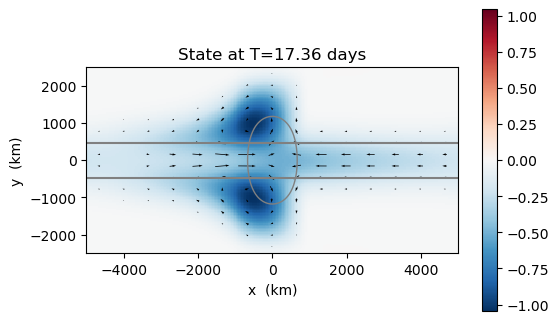

In [268]:
fig, ax = plt.subplots(dpi=100, figsize=(6, 4))

#(height_betax2-height_betax2.mean()).plot(ax=ax, vmin=-0.2, vmax=0.2, cmap='coolwarm')
height_betax2.plot(ax=ax)
forcing_betax2.plot.contour(ax=ax, levels=[-1*abs(forcing_betax2).max()/2], 
                     colors='grey', 
                     linestyles='-', linewidths=1)

x,y=np.meshgrid(height_betax2.x, height_betax2.y)
plot_wind_arrows(atmos_betax2, (x,y), narrows=(15,15), hide_below=0.05, color='k')

ax.hlines(y=466, xmin=-5000, xmax=5000, color='grey')
ax.hlines(y=-466, xmin=-5000, xmax=5000, color='grey')

ax.set_aspect('equal')
ax.set_xlabel('x  (km)')
ax.set_ylabel('y  (km)')

ax.set_title('State at T=%.2f days' % (atmos.t / 86400.0))

#plt.colorbar()

In [260]:
%%time
atmos_betax1, height_betax1, forcing_betax1 = run_linear_model()

Equatorial deformation radius = 659.0977489045391 (km)
0


/gws/nopw/j04/aopp/andreww/DPhil_misc/MatGill_CRM/shallow_water_model/arakawac.py:150: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([self.u, self.v, self.phi])
/home/users/andreww/miniconda3/envs/plumeworld/lib/python3.7/site-packages/ipykernel_launcher.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/gws/nopw/j04/aopp/andreww/DPhil_misc/MatGill_CRM/shallow_water_model/shallow_water.py:192: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differ

434
868
1302
1736
2170
2604
3038
3472
3906
4340
CPU times: user 22.1 s, sys: 614 ms, total: 22.7 s
Wall time: 22.7 s


/gws/nopw/j04/aopp/andreww/DPhil_misc/MatGill_CRM/shallow_water_model/plotting.py:30: RuntimeWarning: divide by zero encountered in true_divide
  np.ma.masked_where(velnorm.T < hide_below, (v / np.sqrt(velmax**2 - u**2)).T)[arrow_spacing],


Text(0.5, 1.0, 'State at T=17.36 days')

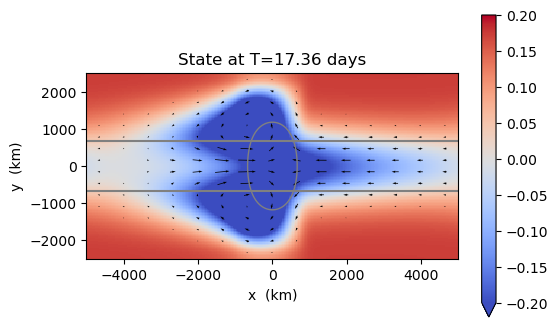

In [261]:
fig, ax = plt.subplots(dpi=100, figsize=(6, 4))

(height_betax1-height_betax1.mean()).plot(ax=ax, vmin=-0.2, vmax=0.2, cmap='coolwarm')

forcing_betax1.plot.contour(ax=ax, levels=[-1*abs(forcing_betax1).max()/2], 
                     colors='grey', 
                     linestyles='-', linewidths=1)

x,y=np.meshgrid(height_betax1.x, height_betax1.y)
plot_wind_arrows(atmos_betax1, (x,y), narrows=(15,15), hide_below=0.05, color='k')

ax.hlines(y=659, xmin=-5000, xmax=5000, color='grey')
ax.hlines(y=-659, xmin=-5000, xmax=5000, color='grey')

ax.set_aspect('equal')
ax.set_xlabel('x  (km)')
ax.set_ylabel('y  (km)')

ax.set_title('State at T=%.2f days' % (atmos.t / 86400.0))


In [262]:
%%time

atmos_betax0p5, height_betax0p5, forcing_betax0p5 = run_linear_model(beta=1.14e-11)

Equatorial deformation radius = 932.1049754303762 (km)
0


/gws/nopw/j04/aopp/andreww/DPhil_misc/MatGill_CRM/shallow_water_model/arakawac.py:150: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([self.u, self.v, self.phi])
/home/users/andreww/miniconda3/envs/plumeworld/lib/python3.7/site-packages/ipykernel_launcher.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/gws/nopw/j04/aopp/andreww/DPhil_misc/MatGill_CRM/shallow_water_model/shallow_water.py:192: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differ

434
868
1302
1736
2170
2604
3038
3472
3906
4340
CPU times: user 21.9 s, sys: 500 ms, total: 22.4 s
Wall time: 22.4 s


/gws/nopw/j04/aopp/andreww/DPhil_misc/MatGill_CRM/shallow_water_model/plotting.py:30: RuntimeWarning: divide by zero encountered in true_divide
  np.ma.masked_where(velnorm.T < hide_below, (v / np.sqrt(velmax**2 - u**2)).T)[arrow_spacing],


Text(0.5, 1.0, 'State at T=17.36 days')

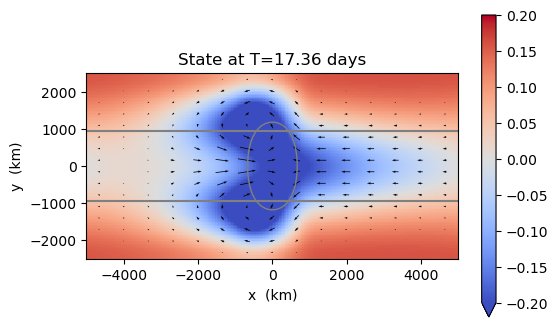

In [263]:
fig, ax = plt.subplots(dpi=100, figsize=(6, 4))

(height_betax0p5-height_betax0p5.mean()).plot(ax=ax, vmin=-0.2, vmax=0.2, cmap='coolwarm')
#height_betax0p5.plot(ax=ax)
forcing_betax0p5.plot.contour(ax=ax, levels=[-1*abs(forcing_betax0p5).max()/2], 
                     colors='grey', 
                     linestyles='-', linewidths=1)

x,y=np.meshgrid(height_betax0p5.x, height_betax0p5.y)
plot_wind_arrows(atmos_betax0p5, (x,y), narrows=(15,15), hide_below=0.05, color='k')

ax.hlines(y=932, xmin=-5000, xmax=5000, color='grey')
ax.hlines(y=-932, xmin=-5000, xmax=5000, color='grey')

ax.set_aspect('equal')
ax.set_xlabel('x  (km)')
ax.set_ylabel('y  (km)')

ax.set_title('State at T=%.2f days' % (atmos.t / 86400.0))

#plt.colorbar()

In [264]:
%%time

atmos_betax0p25, height_betax0p25, forcing_betax0p25 = run_linear_model(beta=2.28e-11*0.25)

Equatorial deformation radius = 1318.1954978090782 (km)
0


/gws/nopw/j04/aopp/andreww/DPhil_misc/MatGill_CRM/shallow_water_model/arakawac.py:150: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([self.u, self.v, self.phi])
/home/users/andreww/miniconda3/envs/plumeworld/lib/python3.7/site-packages/ipykernel_launcher.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/gws/nopw/j04/aopp/andreww/DPhil_misc/MatGill_CRM/shallow_water_model/shallow_water.py:192: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differ

434
868
1302
1736
2170
2604
3038
3472
3906
4340
CPU times: user 22 s, sys: 300 ms, total: 22.3 s
Wall time: 22.3 s


/gws/nopw/j04/aopp/andreww/DPhil_misc/MatGill_CRM/shallow_water_model/plotting.py:30: RuntimeWarning: divide by zero encountered in true_divide
  np.ma.masked_where(velnorm.T < hide_below, (v / np.sqrt(velmax**2 - u**2)).T)[arrow_spacing],


Text(0.5, 1.0, 'State at T=17.36 days')

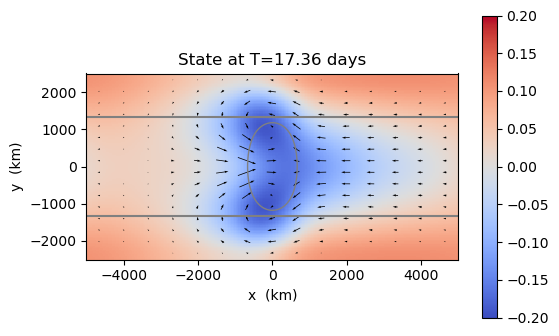

In [265]:
fig, ax = plt.subplots(dpi=100, figsize=(6, 4))

(height_betax0p25-height_betax0p25.mean()).plot(ax=ax, vmin=-0.2, vmax=0.2, cmap='coolwarm')

forcing_betax0p25.plot.contour(ax=ax, levels=[-1*abs(forcing_betax0p25).max()/2], 
                     colors='grey', 
                     linestyles='-', linewidths=1)

x,y=np.meshgrid(height_betax0p25.x, height_betax0p25.y)
plot_wind_arrows(atmos_betax0p25, (x,y), narrows=(15,15), hide_below=0.05, color='k')

ax.hlines(y=1318, xmin=-5000, xmax=5000, color='grey')
ax.hlines(y=-1318, xmin=-5000, xmax=5000, color='grey')

ax.set_aspect('equal')
ax.set_xlabel('x  (km)')
ax.set_ylabel('y  (km)')

ax.set_title('State at T=%.2f days' % (atmos.t / 86400.0))

#plt.colorbar()

In [266]:
%%time

atmos_betax0p15, height_betax0p15, forcing_betax0p15 = run_linear_model(beta=2.28e-11*0.15)

Equatorial deformation radius = 1701.783070020052 (km)
0


/gws/nopw/j04/aopp/andreww/DPhil_misc/MatGill_CRM/shallow_water_model/arakawac.py:150: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([self.u, self.v, self.phi])
/home/users/andreww/miniconda3/envs/plumeworld/lib/python3.7/site-packages/ipykernel_launcher.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/gws/nopw/j04/aopp/andreww/DPhil_misc/MatGill_CRM/shallow_water_model/shallow_water.py:192: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differ

434
868
1302
1736
2170
2604
3038
3472
3906
4340
CPU times: user 25 s, sys: 262 ms, total: 25.3 s
Wall time: 25.3 s


/gws/nopw/j04/aopp/andreww/DPhil_misc/MatGill_CRM/shallow_water_model/plotting.py:30: RuntimeWarning: divide by zero encountered in true_divide
  np.ma.masked_where(velnorm.T < hide_below, (v / np.sqrt(velmax**2 - u**2)).T)[arrow_spacing],


Text(0.5, 1.0, 'State at T=17.36 days')

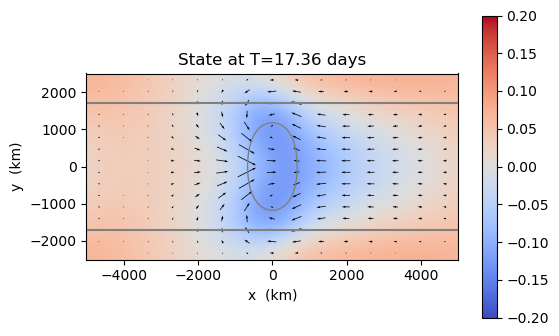

In [267]:
fig, ax = plt.subplots(dpi=100, figsize=(6, 4))

(height_betax0p15-height_betax0p15.mean()).plot(ax=ax, vmin=-0.2, vmax=0.2, cmap='coolwarm')
#height_betax0p1.plot(ax=ax)
forcing_betax0p15.plot.contour(ax=ax, levels=[-1*abs(forcing_betax0p15).max()/2], 
                     colors='grey', 
                     linestyles='-', linewidths=1)

x,y=np.meshgrid(height_betax0p15.x, height_betax0p15.y)
plot_wind_arrows(atmos_betax0p15, (x,y), narrows=(15,15), hide_below=0.05, color='k')

ax.hlines(y=1701, xmin=-5000, xmax=5000, color='grey')
ax.hlines(y=-1701, xmin=-5000, xmax=5000, color='grey')

ax.set_aspect('equal')
ax.set_xlabel('x  (km)')
ax.set_ylabel('y  (km)')

ax.set_title('State at T=%.2f days' % (atmos.t / 86400.0))

#plt.colorbar()